In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
data_1h = pd.read_parquet('../../data/edison/data')
data_1h_sample = data_1h[['tempo','y']].rename(columns={'tempo':'ds'})


In [2]:

data_1h_train = data_1h_sample[data_1h_sample.ds<'2020-09-01']
data_1h_validation = data_1h_sample[data_1h_sample.ds.between('2020-09-01','2021-01-01')]
data_1h_test = data_1h_sample[data_1h_sample.ds>'2021-01-01']

In [3]:
##i had to fill these otherwiese neuralprophet will break
data_1h_train[pd.isnull(data_1h_train.y)]

,ds,y
4320,2019-06-29 23:00:00,NaN
4321,2019-06-30 00:00:00,NaN
4322,2019-06-30 01:00:00,NaN
4323,2019-06-30 02:00:00,NaN
4324,2019-06-30 03:00:00,NaN
...,...,...
13122,2020-06-30 17:00:00,NaN
13123,2020-06-30 18:00:00,NaN
13124,2020-06-30 19:00:00,NaN
13125,2020-06-30 20:00:00,NaN


In [5]:
data_1h_train.y.interpolate(inplace=True)
data_1h_validation.y.interpolate(inplace=True)
data_1h_validation.fillna(method='bfill',inplace=True)
data_1h_test['y_orig']=data_1h_test.y.values.copy()
data_1h_test.y.interpolate(inplace=True)
data_1h_test.fillna(method='bfill',inplace=True)


/tmp/ipykernel_1309153/3981704086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1h_train.y.interpolate(inplace=True)
/tmp/ipykernel_1309153/3981704086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1h_validation.y.interpolate(inplace=True)
/tmp/ipykernel_1309153/3981704086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1h_validation.fillna(method='bfill',inplace=True)
/tmp/ipykernel_1309153/3981704086.py:

In [6]:
from neuralprophet import NeuralProphet
m = NeuralProphet(growth='off',changepoints=100,
                  weekly_seasonality=True,
                   yearly_seasonality=True,
                   daily_seasonality=True,
                  seasonality_reg=100.1,
                  n_forecasts=60,
                  num_hidden_layers=36, #24
                  d_hidden =512, #256
                  epochs=60,
                  batch_size=64,ar_reg=110,
                  n_lags=1*24,learning_rate=0.0005,
                impute_missing=True,
                  global_normalization=True,
                  
                 )
m = m.add_country_holidays("IT")


#m = m.add_lagged_regressor(names=region_fixed) #, only_last_value=True)

metrics = m.fit(data_1h_train[['ds','y']],validation_df=data_1h_validation)


INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.993% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as H
WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/utils.py:205: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  additive_events_dims = additive_events_dims.append(

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/utils.py:205: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  additive_events_dims = additive_events_dims.append(

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-pa

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)



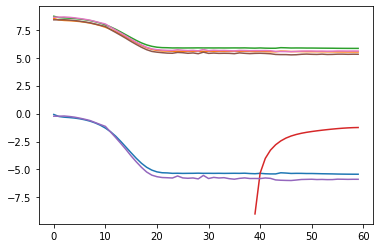

In [23]:
plt.plot(np.log(metrics))

In [24]:
forecast = m.predict(data_1h_test[['ds','y']])

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.991% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.991% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

WARNING - (py.warnings._showwarnm

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - /home/agob

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - /home/agobbi/.conda/envs/edison/lib/python3.10/site-packages/neuralprophet/forecast

In [25]:
#fig_forecast = m.plot(forecast)

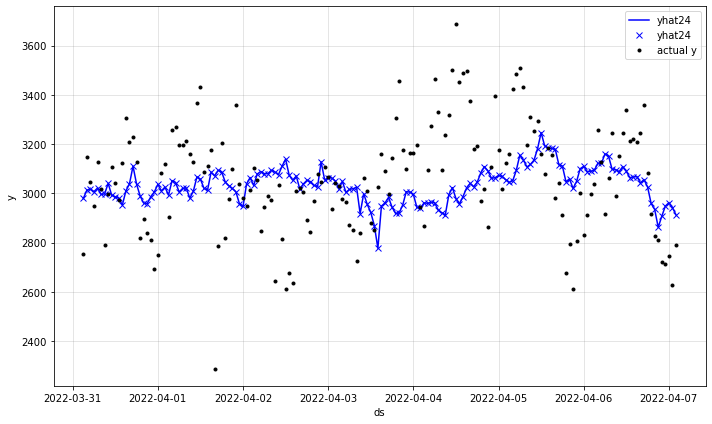

In [29]:
m = m.highlight_nth_step_ahead_of_each_forecast(24)
fig = m.plot(forecast[-7*24:])

176.63490586615646 394.05000819542636 319.6582274817938


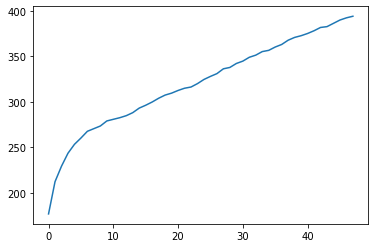

In [27]:
def rmse(x,y):
    x = x.astype(float)
    y = y.astype(float)
    idx = list(np.where(~np.isnan(x*y))[0])
    return np.sqrt(mean_squared_error(x[idx],y[idx]))
error = []
for i in range(1,49):
    error.append(rmse(forecast['y'].values,forecast[f'yhat{i}'].values))
plt.plot(error)
print(min(error), max(error),np.mean(error))

178.041505023706 393.15342342055135 320.06608362678486


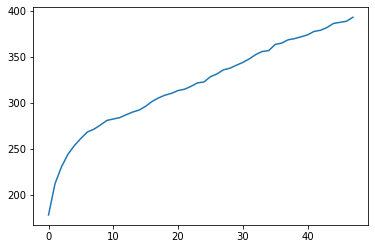

In [21]:
def rmse(x,y):
    x = x.astype(float)
    y = y.astype(float)
    idx = list(np.where(~np.isnan(x*y))[0])
    return np.sqrt(mean_squared_error(x[idx],y[idx]))
error = []
for i in range(1,49):
    error.append(rmse(forecast['y'].values,forecast[f'yhat{i}'].values))
plt.plot(error)
print(min(error), max(error),np.mean(error))